# Laboratorio #2 
## Multi-armed Bandit 
### CC3104 Reinforcement Learning
### Integrantes:
- Diego Leiva
- Pablo Orellana

multiarmed_bandit.py  (author: Anson Wong / git: ankonzoid)

We solve the multi-armed bandit problem using a classical epsilon-greedy
agent with reward-average sampling as the estimate to action-value Q.
This algorithm follows closely with the notation of Sutton's RL textbook.

We set up bandit arms with fixed probability distribution of success,
and receive stochastic rewards from each arm of +1 for success,
and 0 reward for failure.

The incremental update rule action-value Q for each (action a, reward r):   
n += 1  
Q(a) <- Q(a) + 1/n * (r - Q(a)) 

where:  
n = number of times action "a" was performed    
Q(a) = value estimate of action "a" 
r(a) = reward of sampling action bandit (bandit) "a"    

Derivation of the Q incremental update rule:    
Q_{n+1}(a)  
= 1/n * (r_1(a) + r_2(a) + ... + r_n(a))    
= 1/n * ((n-1) * Q_n(a) + r_n(a))   
= 1/n * (n * Q_n(a) + r_n(a) - Q_n(a))  
= Q_n(a) + 1/n * (r_n(a) - Q_n(a))  

#### Librerias

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(0)

#### Entorno

In [3]:
class Environment:
    def __init__(self, probs):
       # Success probabilities for each arm.
        self.probs = probs

    def step(self, action):
        # Pull arm and get stochastic reward (1 for success, 0 for failure)
        return 1 if (np.random.random()  < self.probs[action]) else 0

#### Agente

In [4]:
class Agent:

    def __init__(self, nActions, eps, strategy, min_eps, decay_rate):
        self.nActions = nActions # Number of actions
        self.eps = eps # probability of exploration vs exploitation.
        self.n = np.zeros(nActions, dtype=int) # action counts n(a)
        self.Q = np.zeros(nActions, dtype=float) # value Q(a)
        
        self.strategy = strategy
        self.min_eps = min_eps
        self.decay_rate = decay_rate
        self.time_step = 0


    def update_Q(self, action, reward):
        # Update Q action-value given (action, reward)
        self.n[action] += 1
        self.Q[action] += (1.0/self.n[action]) * (reward - self.Q[action])

    def explore_exploit(self, epsilon):
        """
        Explore or exploit based on epsilon value.
        Args:
            epsilon (float): Probability of exploration (0 <= epsilon <= 1)
        Returns:
            int: Action index corresponding to the arm taken.
        """
        # Epsilon-greedy exploration-exploitation
        if np.random.random() < epsilon:
            return np.random.randint(self.nActions) # Randomly explore
        else:
            return np.argmax(self.Q) # Exploit the best action

    def get_action(self):
        """ 
        Get action based on the current strategy. 
        1. Greedy: Always exploit the best action.
        2. Static Epsilon-Greedy: Explore or exploit based on a static epsilon.
        3. Decaying Epsilon-Greedy: Explore or exploit based on a decaying epsilon.

        Args:
            None

        Returns:
            int: Action index corresponding to the arm taken.
        """
        # Greedy strategy
        if self.strategy == 'greedy':
            return np.argmax(self.Q) # Always exploit the best action
        
        # Epsilon-greedy with static epsilon strategy
        elif self.strategy == 'static_eps':
            return self.explore_exploit(self.eps) # Explore or exploit based on static epsilon
            
        # Epsilon-greedy with decaying epsilon strategy
        elif self.strategy == 'decaying_eps':
            # decay epsilon over time exponentially
            current_epsilon = max(self.min_eps, self.eps * np.exp(-self.decay_rate * self.time_step))
            self.time_step += 1 # increment time step
            return self.explore_exploit(current_epsilon) # Explore or exploit based on decaying epsilon
        
        # If an unknown strategy is provided, raise an error
        else:
            raise ValueError("Unknown strategy: {}".format(self.strategy))

#### Experimento

In [5]:
def experiment(probs, N_episodes, eps, strategy, min_eps, decay_rate):
    """Start multi-armed bandit simulation"""
    # Initialize environment and agent
    env = Environment(probs) # initialize arm probabilities
    agent = Agent(len(env.probs), eps, strategy, min_eps, decay_rate)  # initialize agent

    # Get the best action based on arm probabilities 
    best_action = np.argmax(env.probs)  # best action based on arm probabilities
    actions, rewards, best_hits = [], [], [] # lists to store actions, rewards and best hits

    # Run the experiment for N_episodes
    for _ in range(N_episodes):
        action = agent.get_action() # sample policy # integer correcponding to the arm taken.
        reward = env.step(action) # take step + get reward # integer 0/1
        agent.update_Q(action, reward) # update Q
        
        
        actions.append(action) # list of ints
        rewards.append(reward) # list of ints
        best_hits.append(1 if action == best_action else 0) # 1 if action is the best action, else 0

    return np.array(actions), np.array(rewards), np.array(best_hits)

#### Configuración

In [6]:
probs = [0.10, 0.50, 0.60, 0.80, 0.10, 0.25, 0.60, 0.45, 0.75, 0.65] 
N_steps = 1000 # number of steps 
N_experiments = 5000 # number of experiments to perform
save_fig = True # save figures
output_dir = "figures" # directory to save figures

#### Múltiples Experimentos

In [7]:
def run_experiment_batch(strategy, eps, min_eps, decay_rate, N_experiments, N_steps, probs):
    """
    Run a batch of experiments for the multi-armed bandit problem. 
    Args:
        strategy (str): Strategy to use ('greedy', 'static_eps', 'decaying_eps').
        eps (float): Epsilon value for exploration (0 <= eps <= 1).
        min_eps (float): Minimum epsilon value for decaying epsilon strategy.
        decay_rate (float): Decay rate for the decaying epsilon strategy.
        N_experiments (int): Number of experiments to run.
    
    Returns:
        dict: A dictionary containing average reward, average best action,
    """
    R = np.zeros(N_steps)   # Reward history sum
    A = np.zeros((N_steps, len(probs))) # action history sum
    best_hits_total = np.zeros(N_steps) # Total best hits across all experiments
    
    # Initialize progress bar to track experiments  
    pbar = tqdm(range(N_experiments), desc=f"{strategy} (ε={eps})")

    # Run experiments
    for i in pbar:
        # Run a single experiment with the given parameters
        actions, rewards, best_hits = experiment(probs, N_steps, eps, strategy, min_eps, decay_rate)
        
        R += rewards # # Adding rewards for every time step across all experiments
        best_hits_total += best_hits

        for j, a in enumerate(actions):
            # Each cell holds number of actions a in time step j across all experiments
            A[j][a] += 1 # increment action count for action a at time step j

        # Calculate average reward for the current experiment
        reward_avg = np.sum(rewards) / len(rewards)

        # Update progress bar with current experiment status
        pbar.set_postfix({
            "Experiment": f"{i+1}/{N_experiments}",
            "Steps": N_steps,
            "Reward Avg": f"{reward_avg:.3f}"
        })

    # Calculate average metrics across all experiments
    # Average reward, average best action, and cumulative reward
    avg_reward = R / N_experiments
    avg_best_action = best_hits_total / N_experiments
    cumulative_reward = np.cumsum(R) / N_experiments

    # Return the results as a dictionary
    return {
        "avg_reward": avg_reward,
        "avg_best_action": avg_best_action,
        "cumulative_reward": cumulative_reward,
        "action_counts": A
    }

#### Ejecución de Experimentos con estrategias

In [8]:
# Define strategies and epsilon values
# Each strategy is a tuple of (strategy_name, epsilon_value)
strategies = [
    ("greedy", 0.0),
    ("static_eps", 0.01),
    ("static_eps", 0.05),
    ("static_eps", 0.1),
    ("decaying_eps", 0.01),
    ("decaying_eps", 0.05),
    ("decaying_eps", 0.1),
]

# Initialize results dictionary to store results for each strategy and epsilon value
results = {}

# Run simulations for each strategy and epsilon value
# This will run the experiments in parallel for each strategy and epsilon value
for strategy, eps_val in strategies:
    # Print the current strategy and epsilon value being run
    print(f"Running strategy={strategy}, ε={eps_val}")

    # Run the simulation batch for the current strategy and epsilon value
    # Store the results in the results dictionary with a tuple key (strategy, eps_val)
    results[(strategy, eps_val)] = run_experiment_batch(
        strategy=strategy,
        eps=eps_val,
        min_eps=0.01,
        decay_rate=0.001,
        N_experiments=N_experiments,
        N_steps=N_steps,
        probs=probs
    )

Running strategy=greedy, ε=0.0


greedy (ε=0.0): 100%|██████████| 5000/5000 [00:29<00:00, 170.95it/s, Experiment=5000/5000, Steps=1000, Reward Avg=0.093]


Running strategy=static_eps, ε=0.01


static_eps (ε=0.01): 100%|██████████| 5000/5000 [00:31<00:00, 156.67it/s, Experiment=5000/5000, Steps=1000, Reward Avg=0.352]


Running strategy=static_eps, ε=0.05


static_eps (ε=0.05): 100%|██████████| 5000/5000 [00:31<00:00, 158.30it/s, Experiment=5000/5000, Steps=1000, Reward Avg=0.758]


Running strategy=static_eps, ε=0.1


static_eps (ε=0.1): 100%|██████████| 5000/5000 [00:31<00:00, 156.92it/s, Experiment=5000/5000, Steps=1000, Reward Avg=0.674]


Running strategy=decaying_eps, ε=0.01


decaying_eps (ε=0.01): 100%|██████████| 5000/5000 [00:36<00:00, 135.83it/s, Experiment=5000/5000, Steps=1000, Reward Avg=0.414]


Running strategy=decaying_eps, ε=0.05


decaying_eps (ε=0.05): 100%|██████████| 5000/5000 [00:37<00:00, 134.22it/s, Experiment=5000/5000, Steps=1000, Reward Avg=0.686]


Running strategy=decaying_eps, ε=0.1


decaying_eps (ε=0.1): 100%|██████████| 5000/5000 [00:36<00:00, 135.97it/s, Experiment=5000/5000, Steps=1000, Reward Avg=0.775]


#### Gráficos

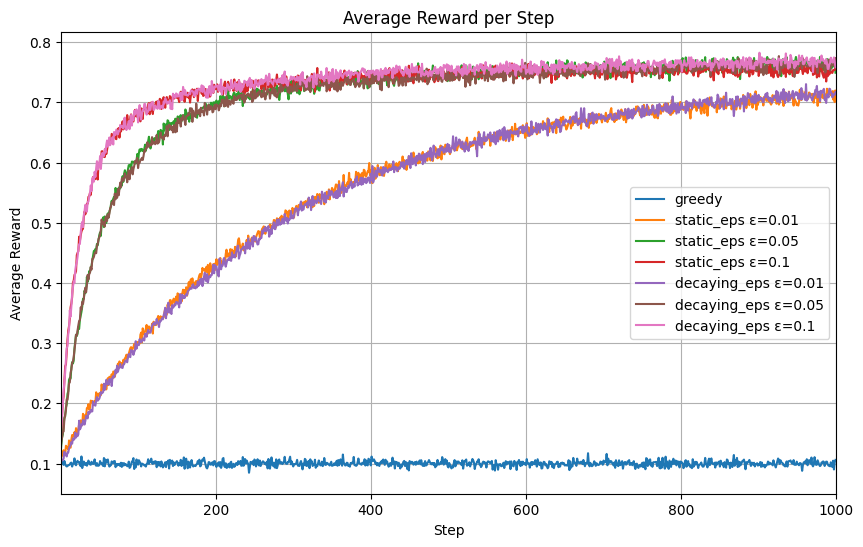

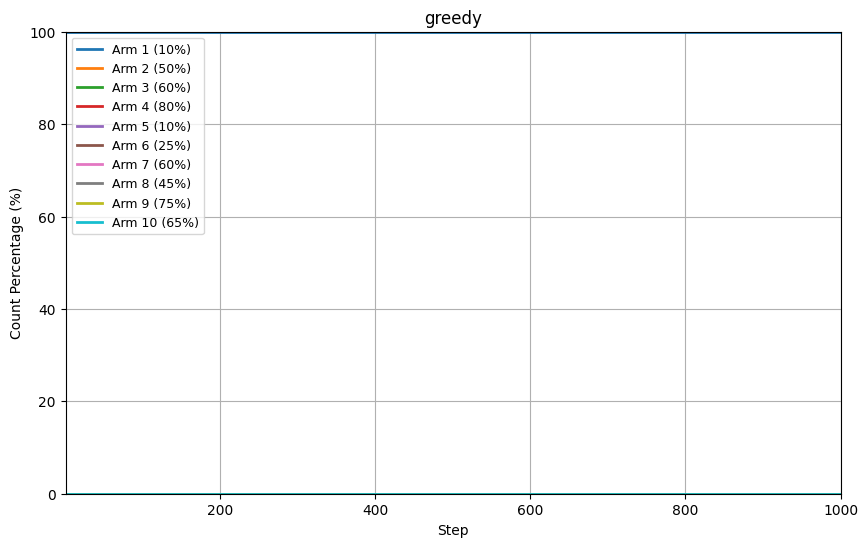

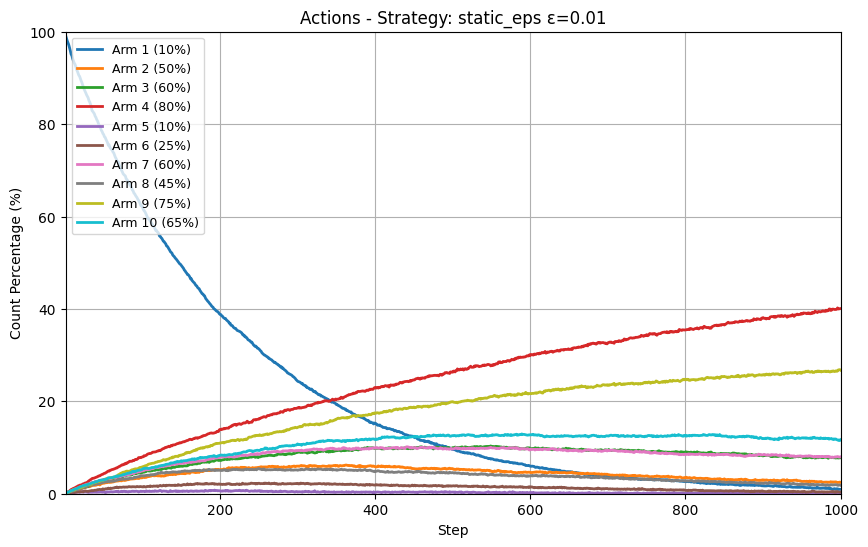

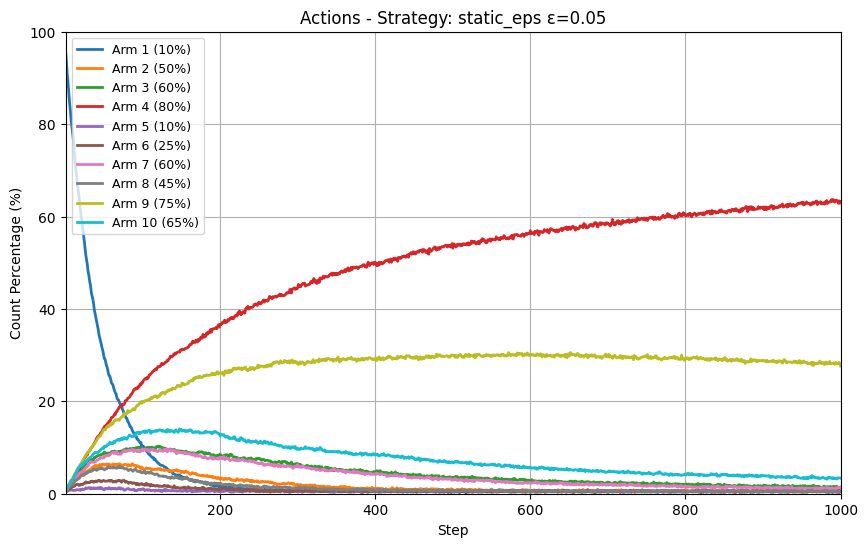

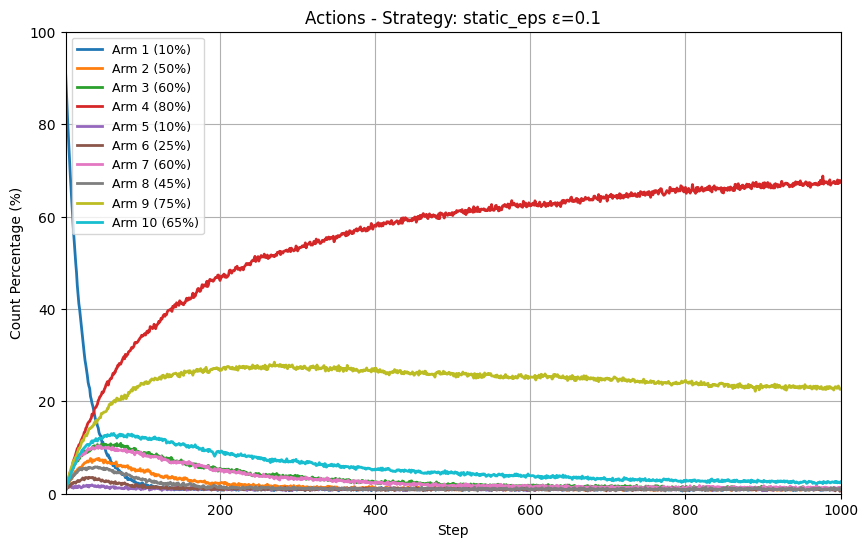

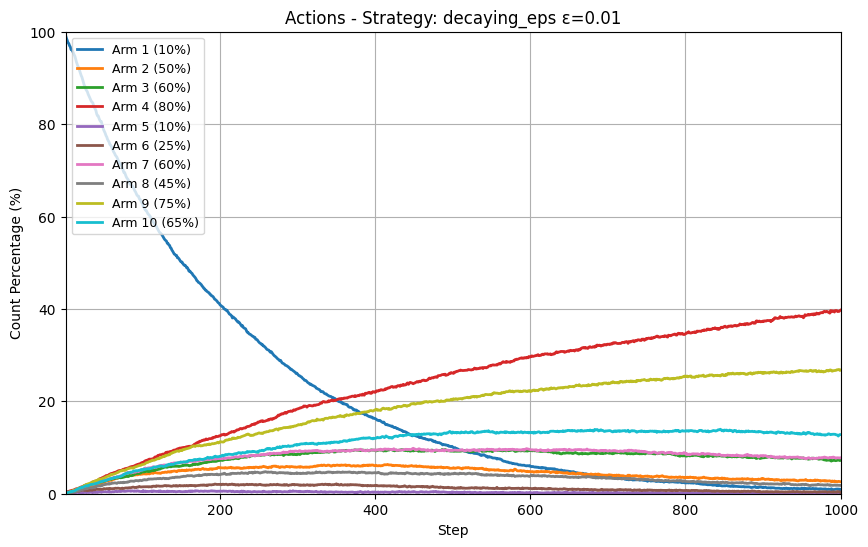

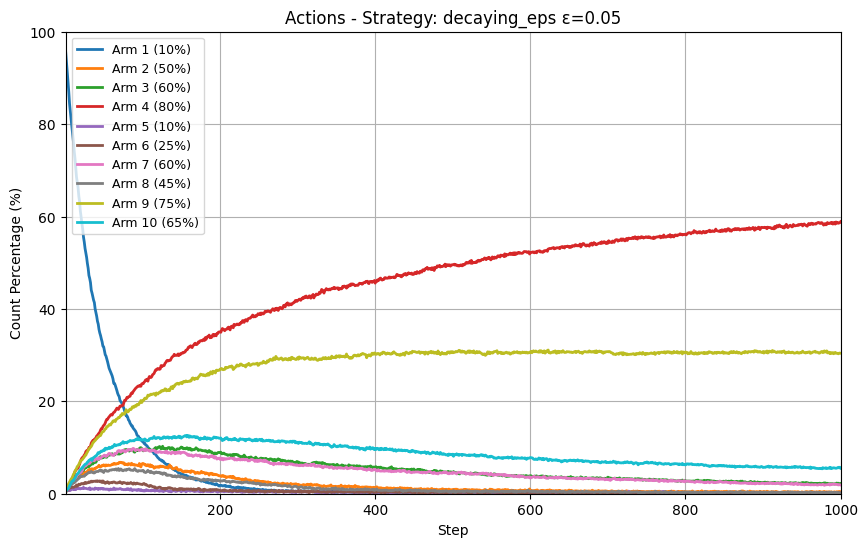

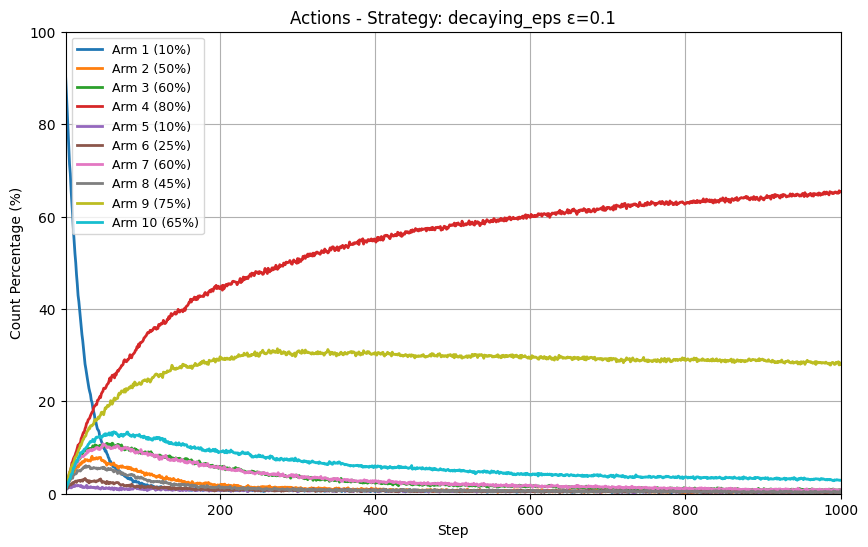

In [9]:
# Settings for saving figures
if save_fig and not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Plot Rewards results
plt.figure(figsize=(10,6))
for key, val in results.items():
    label = f"{key[0]} ε={key[1]}" if key[0] != "greedy" else "greedy"
    plt.plot(val["avg_reward"], label=label)
plt.title("Average Reward per Step")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.legend()
plt.grid()
plt.xlim([1, N_steps])
if save_fig:
    plt.savefig(os.path.join(output_dir, "rewards.png"), bbox_inches="tight")

plt.show()
plt.close()

# Plot Action results
for key, val in results.items():
    A = val["action_counts"]
    plt.figure(figsize=(10,6))
    for i in range(len(probs)):
        A_pct = 100 * A[:, i] / N_experiments
        # Plotting line chart for just 1 action i at a time.
        plt.plot(np.arange(1, N_steps+1), A_pct, label=f"Arm {i+1} ({100*probs[i]:.0f}%)", linewidth=2)

    # Plot title and labels
    plt.title(f"Actions - Strategy: {key[0]} ε={key[1]}" if key[0] != "greedy" else "greedy")
    plt.xlabel("Step")
    plt.ylabel("Count Percentage (%)")
    plt.legend(loc='upper left', fontsize=9)
    plt.grid()
    plt.xlim([1, N_steps])
    plt.ylim([0, 100])
    if save_fig:
        filename = f"actions_{key[0]}_{key[1]}.png".replace(".", "")
        plt.savefig(os.path.join(output_dir, filename), bbox_inches="tight")
    
    plt.show()
    plt.close()

#### Preguntas

- **¿Cuál de los algoritmos y configuraciones presenta el mejor desempeño general?**    
    El algoritmo con mejor desempeño fue el Epsilon Greedy con epsilon variable (`decaying_eps`) con un valor inicial de ε = 0.1. Con esta configuación se logró alcanzar un promedio de recompensas más altas en un periodo más corto de tiempo, y a nivel general es la configuración con más recompensas en el paso 1000. Gracias a que comienza con una buena exploración y conforme pasa el tiempo reduce ε, comenzado a explotar más el conocimiento adquirido.

- **¿Cómo influye el valor de epsilon en el comportamiento y rendimiento del agente?**  
    El valor de ε es el que controla ese equilibrio entre la exploración y la explotación del entorno. Entonces cuanto tenemos valores bajos como 0.01, el agente explora muy poco, lo que puede llevar a que explote de manera prematura una acción que pueda parecer buena al inicio, pero que en realidad no la es a largo plazo. Mientras que cuado hay un valor alto como el de 0.1 entonces los agentes exploran mucho más al inicio, lo que permite tener un mejor conocimiento del entorno, y por ende ayuda a descubrir la mejor acción, sin embargo, esto implica que se explote poco el conocimiento adquirido. Por lo tanto usar un ε variable 

- **¿En qué escenarios podría ser más conveniente utilizar una estrategia con epsilon variable en lugar de una estática?**  
    Ahora la estrategia de variar el valor de ε es conveniente cuando se desconoce el entorno y hay muchas acciones posibles, y también cuando hay una cantidad de episodios alta, porque de esta manera hay suficiente tiempo para explorar al inicio para encontrar la mejor acción y luego explotar ese conocimiento el resto de episodios, logrando un aprendizaje progresivo que lleve a resultads óptimos.